Imports

In [1]:
import utils.bourso as bourso
import utils.inputs as inputs
import utils.helper_functions as hf

from datetime import date, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Config

In [2]:
buy_time = 'Open'
loss_limit = 0.997

cumulated_probs_target = 0.9

fee = 0.002

download_days = 500 #should be > 151 = 90 (input days) * 7/5 (days per week) * 1.2 (margin in case of vacations)

tickers = ['ACKB.BR', 'AED.BR', 'AGS.BR', 'ARGX.BR', 'AZE.BR', 'BEKB.BR', 'COFB.BR', 'COLR.BR', 'DIE.BR', 'ELI.BR', 'EURN.BR', 'FAGR.BR', 'GBLB.BR', 'KBCA.BR', 'MELE.BR', 'ONTEX.BR', 'PROX.BR', 'SHUR.BR', 'SOLB.BR', 'TNET.BR', 'UCB.BR', 'VGP.BR', 'WDP.BR', 'XIOR.BR', 'ALK-B.CO', 'ALMB.CO', 'AMBU-B.CO', 'MAERSK-B.CO', 'BAVA.CO', 'BIOPOR.CO', 'BOOZT-DKK.CO', 'AOJ-B.CO', 'CARL-B.CO', 'CBRAIN.CO', 'CHEMM.CO', 'COLO-B.CO', 'COLUM.CO', 'DNORD.CO', 'DANSKE.CO', 'DFDS.CO', 'FLS.CO', 'GMAB.CO', 'GN.CO', 'GREENH.CO', 'HLUN-A.CO', 'HLUN-B.CO', 'HH.CO', 'ISS.CO', 'JYSK.CO', 'MATAS.CO', 'NETC.CO', 'NKT.CO', 'NNIT.CO', 'NDA-DK.CO', 'NOVO-B.CO', 'ORSTED.CO', 'PNDORA.CO', 'RILBA.CO', 'ROCK-B.CO', 'RBREW.CO', 'RTX.CO', 'SHAPE.CO', 'SKJE.CO', 'SPNO.CO', 'SYDB.CO', 'TRMD-A.CO', 'TRYG.CO', 'VWS.CO', 'VJBA.CO', 'DEMANT.CO', 'ZEAL.CO', 'ANA.MC', 'ACX.MC', 'AENA.MC', 'AMP.MC', 'APPS.MC', 'AI.MC', 'A3M.MC', 'ADX.MC', 'BBVA.MC', 'SAN.MC', 'BKY.MC', 'BST.MC', 'CABK.MC', 'CLNX.MC', 'LOG.MC', 'CIE.MC', 'ANE.MC', 'EDR.MC', 'ENC.MC', 'GEST.MC', 'DOM.MC', 'GCO.MC', 'IBE.MC', 'ITX.MC', 'COL.MC', 'IAG.MC', 'ROVI.MC', 'MRL.MC', 'MTB.MC', 'NTGY.MC', 'NXT.MC', 'OHLA.MC', 'PHM.MC', 'SPH.MC', 'CASH.MC', 'SCYR.MC', 'TEF.MC', 'UBS.MC', 'VID.MC', 'BFF.MI', 'BGN.MI', 'IF.MI', 'BMPS.MI', 'BPE.MI', 'BPSO.MI', 'PRO.MI', 'BST.MI', 'BAMI.MI', 'BE.MI', 'BNP.MI', 'BC.MI', 'BZU.MI', 'CPR.MI', 'CRL.MI', 'CEM.MI', 'CNHI.MI', 'CE.MI', 'DIS.MI', 'DAN.MI', 'DAL.MI', 'DLG.MI', 'DEA.MI', 'DBK.MI', 'DOV.MI', 'ELN.MI', 'ENAV.MI', 'ENI.MI', 'EPR.MI', 'EXAI.MI', 'FNX.MI', 'RACE.MI', 'FILA.MI', 'FCT.MI', 'FBK.MI', 'US.MI', 'FCM.MI', 'FUL.MI', 'GAMB.MI', 'GE.MI', 'GEO.MI', 'GO.MI', 'GVS.MI', 'HER.MI', 'IE.MI', 'ILTY.MI', 'IGD.MI', 'DNR.MI', 'IP.MI', 'IRE.MI', 'ITW.MI', 'IIG.MI', 'IVG.MI', 'JUVE.MI', 'LR.MI', 'LDO.MI', 'MT.MI', 'MARR.MI', 'MB.MI', 'MFEA.MI', 'MFEB.MI', 'MONC.MI', 'NSP.MI', 'NWL.MI', 'OJM.MI', 'PRL.MI', 'PIRC.MI', 'PRM.MI', 'PRY.MI', 'RWAY.MI', 'RST.MI', 'SFL.MI', 'SPM.MI', 'SCF.MI', 'SFER.MI', 'SL.MI', 'IOT.MI', 'SERI.MI', 'SRG.MI', 'SO.MI', 'STLAM.MI', 'STM.MI', 'TGYM.MI', 'TPRO.MI', 'TIT.MI', 'TITR.MI', 'TEF.MI', 'TEN.MI', 'TRN.MI', 'TKA.MI', 'TNXT.MI', 'TOD.MI', 'TXT.MI', 'UCG.MI', 'DAPP.MI', 'VNT.MI', 'WBD.MI', 'ZV.MI', 'A2A.MI', 'AED.MI', 'ALA.MI', 'AMZN.MI', 'AMP.MI', 'ANIM.MI', 'AV.MI', 'ARIS.MI', 'ASC.MI', 'G.MI', 'AGL.MI', 'AVIO.MI', '2020.OL', 'ABG.OL', 'AFG.OL', 'AMSC.OL', 'ABT.OL', 'ARCH.OL', 'ARR.OL', 'ASA.OL', 'BCS.OL', 'BORR.OL', 'DNB.OL', 'ENTRA.OL', 'EQNR.OL', 'EPR.OL', 'FLNG.OL', 'FRO.OL', 'GOGL.OL', 'GSF.OL', 'HEX.OL', 'JIN.OL', 'NAPA.OL', 'NEXT.OL', 'NAS.OL', 'NRC.OL', 'PEN.OL', 'PHO.OL', 'SAGA.OL', 'SATS.OL', 'SDRL.OL', 'SBO.OL', 'SPOL.OL', 'STB.OL', 'STRO.OL', 'TEL.OL', 'TGS.OL', 'VOW.OL', 'VGM.OL', 'WEST.OL', 'ZAL.OL', 'AALB.AS', 'ABN.AS', 'AXS.AS', 'ADYEN.AS', 'AD.AS', 'AKZA.AS', 'ALFEN.AS', 'ALLFG.AS', 'AMG.AS', 'APAM.AS', 'ARCAD.AS', 'MT.AS', 'ASM.AS', 'ASML.AS', 'ASRNL.AS', 'AVTX.AS', 'BAMNB.AS', 'BFIT.AS', 'CCEP.AS', 'CTPNV.AS', 'DSFIR.AS', 'EXO.AS', 'FAST.AS', 'FUR.AS', 'GLPG.AS', 'HEIJM.AS', 'HEIA.AS', 'HEIO.AS', 'IMCD.AS', 'INGA.AS', 'INPST.AS', 'JDEP.AS', 'TKWY.AS', 'KPN.AS', 'MAREL.AS', 'NN.AS', 'PSH.AS', 'PHARM.AS', 'PHIA.AS', 'PNL.AS', 'PRX.AS', 'REN.AS', 'RWI.AS', 'SBMO.AS', 'SHELL.AS', 'LIGHT.AS', 'TWEKA.AS', 'TOM2.AS', 'URW.AS', 'UNA.AS', 'UMG.AS', 'VLK.AS', 'VPK.AS', 'WHA.AS', 'WKL.AS', 'AAK.ST', 'ABB.ST', 'ACAD.ST', 'ATIC.ST', 'ALIF-B.ST', 'ANOD-B.ST', 'ADDT-B.ST', 'ALFA.ST', 'ALIG.ST', 'ATORX.ST', 'AMBEA.ST', 'AQ.ST', 'ARISE.ST', 'ARJO-B.ST', 'ASSA-B.ST', 'AZN.ST', 'ATCO-A.ST', 'ATCO-B.ST', 'ATRLJ-B.ST', 'ATT.ST', 'AXFO.ST', 'B3.ST', 'BALCO.ST', 'BEGR.ST', 'BEIA-B.ST', 'BEIJ-B.ST', 'BETS-B.ST', 'BETCO.ST', 'BILI-A.ST', 'BILL.ST', 'BIOA-B.ST', 'BIOG-B.ST', 'BONAV-B.ST', 'BONEX.ST', 'BOOZT.ST', 'BUFAB.ST', 'BULTEN.ST', 'BURE.ST', 'BHG.ST', 'CRAD-B.ST', 'CALTX.ST', 'CANTA.ST', 'CAST.ST', 'CATE.ST', 'CLAS-B.ST', 'CLA-B.ST', 'COLL.ST', 'COIC.ST', 'COOR.ST', 'CORE-PREF.ST', 'CRED-A.ST', 'DEDI.ST', 'DIOS.ST', 'DOM.ST', 'DORO.ST', 'DUNI.ST', 'ELUX-B.ST', 'EPRO-B.ST', 'EKTA-B.ST', 'ENQ.ST', 'EOLU-B.ST', 'EPI-A.ST', 'EPI-B.ST', 'EQT.ST', 'ESSITY-B.ST', 'EVO.ST', 'FABG.ST', 'BALD-B.ST', 'FPAR-A.ST', 'FING-B.ST', 'G5EN.ST', 'GIGSEK.ST', 'GETI-B.ST', 'GRNG.ST', 'HNSA.ST', 'HANZA.ST', 'HM-B.ST', 'HEXA-B.ST', 'HTRO.ST', 'HPOL-B.ST', 'HMS.ST', 'HOFI.ST', 'HOLM-B.ST', 'HUFV-A.ST', 'HUM.ST', 'HUSQ-B.ST', 'IAR-B.ST', 'IMMNOV.ST', 'INDU-C.ST', 'INDU-A.ST', 'INSTAL.ST', 'IPCO.ST', 'INTRUM.ST', 'LATO-B.ST', 'INVE-A.ST', 'INVE-B.ST', 'IVSO.ST', 'INWI.ST', 'JM.ST', 'KAR.ST', 'KIND-SDB.ST', 'KINV-B.ST', 'LAGR-B.ST', 'LIFCO-B.ST', 'LIAB.ST', 'LOOMIS.ST', 'LUND-B.ST', 'LUG.ST', 'LUMI.ST', 'MCOV-B.ST', 'MEKO.ST', 'TIGO-SDB.ST', 'MIPS.ST', 'MTG-B.ST', 'MMGR-B.ST', 'MTRS.ST', 'MYCR.ST', 'NCC-B.ST', 'NETI-B.ST', 'NEWA-B.ST', 'NGS.ST', 'NIBE-B.ST', 'NOBI.ST', 'NOLA-B.ST', 'NDA-SE.ST', 'NP3.ST', 'OEM-B.ST', 'PNDX-B.ST', 'PEAB-B.ST', 'PFE.ST', 'PLAZ-B.ST', 'PREV-B.ST', 'PRIC-B.ST', 'QLINEA.ST', 'RATO-B.ST', 'RAY-B.ST', 'REJL-B.ST', 'RESURS.ST', 'SAAB-B.ST', 'SAGA-B.ST', 'SAGA-D.ST', 'SBB-B.ST', 'SAND.ST', 'SCST.ST', 'SHOT.ST', 'SECT-B.ST', 'SECU-B.ST', 'SINT.ST', 'SEB-C.ST', 'SEB-A.ST', 'SKA-B.ST', 'SKF-B.ST', 'SKIS-B.ST', 'SSAB-B.ST', 'SSAB-A.ST', 'STAR-B.ST', 'STE-R.ST', 'SCA-B.ST', 'SHB-A.ST', 'SHB-B.ST', 'SVOL-B.ST', 'SWEC-B.ST', 'SWED-A.ST', 'SOBI.ST', 'SYSR.ST', 'TEL2-B.ST', 'ERIC-B.ST', 'TELIA.ST', 'TETY.ST', 'THULE.ST', 'TOBII.ST', 'TREL-B.ST', 'TROAX.ST', 'VIT-B.ST', 'VITR.ST', 'VOLO.ST', 'VOLV-A.ST', 'VOLV-B.ST', 'VNV.ST', 'WALL-B.ST', 'WIHL.ST', 'XBRANE.ST', 'XVIVO.ST', 'AB.PA', 'ADP.PA', 'AI.PA', 'AIR.PA', 'ALD.PA', 'ALO.PA', 'AMUN.PA', 'APAM.PA', 'MT.PA', 'AKE.PA', 'ATO.PA', 'AUB.PA', 'AVT.PA', 'CS.PA', 'BEN.PA', 'BB.PA', 'BIG.PA', 'BNP.PA', 'BVI.PA', 'CAP.PA', 'CO.PA', 'CRI.PA', 'CLARI.PA', 'COFA.PA', 'ACA.PA', 'BN.PA', 'AM.PA', 'EDEN.PA', 'ELIOR.PA', 'ELIS.PA', 'ENGI.PA', 'ALESK.PA', 'EL.PA', 'ES.PA', 'RF.PA', 'ERF.PA', 'FRVIA.PA', 'GTT.PA', 'RMS.PA', 'NK.PA', 'IPH.PA', 'IPN.PA', 'IPS.PA', 'DEC.PA', 'KOF.PA', 'KER.PA', 'LI.PA', 'OR.PA', 'FDJ.PA', 'LR.PA', 'MC.PA', 'MEDCL.PA', 'MERY.PA', 'ML.PA', 'NANO.PA', 'NEOEN.PA', 'NXI.PA', 'NRG.PA', 'ORA.PA', 'OSE.PA', 'OVH.PA', 'VAC.PA', 'POM.PA', 'PUB.PA', 'RCO.PA', 'RNO.PA', 'SAN.PA', 'SLB.PA', 'SU.PA', 'SCR.PA', 'SESG.PA', 'GLE.PA', 'SW.PA', 'SOI.PA', 'S30.PA', 'SPIE.PA', 'STLAP.PA', 'STMPA.PA', 'TE.PA', 'TEP.PA', 'HO.PA', 'TKO.PA', 'TTE.PA', 'TRI.PA', 'URW.PA', 'FR.PA', 'VK.PA', 'VLA.PA', 'VIE.PA', 'VRLA.PA', 'DG.PA', 'VIV.PA', 'VLTSA.PA', 'MF.PA', 'WLN.PA', 'XFAB.PA']
# tickers = ['ACKB.BR', 'AED.BR', 'AGS.BR']


model_path = './outputs/classifier_model.keras'
scaler_path = './outputs/scaler.pkl'

Download past data

In [3]:
def get_past_date(days_past):
    today = date.today()
    past_date = today - timedelta(days=days_past)
    formatted_date = past_date.strftime('%Y-%m-%d')
    return formatted_date

def days_difference(date1, date2): # can handle date objects and 'YYYY-MM-DD' strings
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)

    difference = abs((date2 - date1).days)
    return difference

In [4]:
start_date = get_past_date(download_days)
today = get_past_date(0)

print(f'start download date: {start_date}')
print(f'today: {today}')
print(f'number of tickers: {len(tickers)}')


start download date: 2023-02-27
today: 2024-07-11
number of tickers: 593


In [5]:
download_past_data = yf.download(tickers, start=start_date, end=today)
df_download_past = pd.DataFrame(download_past_data)
df_download_past_filled = hf.fillnavalues(df_download_past)
# df_download = df_download.dropna(axis='columns', how='all') #remove columns with only nan values

print(df_download_past_filled.tail(3).to_markdown())


[*********************100%%**********************]  593 of 593 completed

24 Failed downloads:
['RST.MI']: Exception('%ticker%: No data found, symbol may be delisted')
['SO.MI', 'URW.AS', 'TKA.MI', 'APAM.PA', 'CNHI.MI', 'ENQ.ST', 'AMZN.MI', 'BNP.MI', 'AED.MI', 'EPR.MI', 'TNET.BR', 'PFE.ST', 'ABT.OL', 'TEF.MI', 'COLL.ST', 'DBK.MI', 'LR.MI', 'AGL.MI', 'STM.MI', 'FUL.MI', 'PRL.MI', 'MT.MI']: Exception('%ticker%: No timezone found, symbol may be delisted')
['MT.PA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-02-27 -> 2024-07-11)')


| Date                |   ('Adj Close', '2020.OL') |   ('Adj Close', 'A2A.MI') |   ('Adj Close', 'A3M.MC') |   ('Adj Close', 'AAK.ST') |   ('Adj Close', 'AALB.AS') |   ('Adj Close', 'AB.PA') |   ('Adj Close', 'ABB.ST') |   ('Adj Close', 'ABG.OL') |   ('Adj Close', 'ABN.AS') |   ('Adj Close', 'ABT.OL') |   ('Adj Close', 'ACA.PA') |   ('Adj Close', 'ACAD.ST') |   ('Adj Close', 'ACKB.BR') |   ('Adj Close', 'ACX.MC') |   ('Adj Close', 'AD.AS') |   ('Adj Close', 'ADDT-B.ST') |   ('Adj Close', 'ADP.PA') |   ('Adj Close', 'ADX.MC') |   ('Adj Close', 'ADYEN.AS') |   ('Adj Close', 'AED.BR') |   ('Adj Close', 'AED.MI') |   ('Adj Close', 'AENA.MC') |   ('Adj Close', 'AFG.OL') |   ('Adj Close', 'AGL.MI') |   ('Adj Close', 'AGS.BR') |   ('Adj Close', 'AI.MC') |   ('Adj Close', 'AI.PA') |   ('Adj Close', 'AIR.PA') |   ('Adj Close', 'AKE.PA') |   ('Adj Close', 'AKZA.AS') |   ('Adj Close', 'ALA.MI') |   ('Adj Close', 'ALD.PA') |   ('Adj Close', 'ALESK.PA') |   ('Adj Close', 'ALFA.ST') |   ('Adj Close'

In [6]:
last_index = df_download_past_filled.index[-1]
last_download_past_date = last_index.date()
print(f'last download date: {last_download_past_date}')

download_missing_days = days_difference(today, last_download_past_date)
print(f'download missing days: {download_missing_days}')

# if download_missing_days > 1:
#     raise ValueError("Too many download missing days")


last download date: 2024-07-10
download missing days: 1


Download today's data

In [7]:
bourso_tickers = bourso.convert_yahoo_to_bourso_tickers(tickers)

print(bourso_tickers)

['FF11-ACKB', 'FF11-AED', 'FF11-AGS', 'FF11-ARGX', 'FF11-AZE', 'FF11-BEKB', 'FF11-COFB', 'FF11-COLR', 'FF11-DIE', 'FF11-ELI', 'FF11-EURN', 'FF11-FAGR', 'FF11-GBLB', 'FF11-KBCA', 'FF11-MELE', 'FF11-ONTEX', 'FF11-PROX', 'FF11-SHUR', 'FF11-SOLB', 'FF11-TNET', 'FF11-UCB', 'FF11-VGP', 'FF11-WDP', 'FF11-XIOR', 'ALK-B.CO not converted', 'ALMB.CO not converted', 'AMBU-B.CO not converted', 'MAERSK-B.CO not converted', 'BAVA.CO not converted', 'BIOPOR.CO not converted', 'BOOZT-DKK.CO not converted', 'AOJ-B.CO not converted', 'CARL-B.CO not converted', 'CBRAIN.CO not converted', 'CHEMM.CO not converted', 'COLO-B.CO not converted', 'COLUM.CO not converted', 'DNORD.CO not converted', 'DANSKE.CO not converted', 'DFDS.CO not converted', 'FLS.CO not converted', 'GMAB.CO not converted', 'GN.CO not converted', 'GREENH.CO not converted', 'HLUN-A.CO not converted', 'HLUN-B.CO not converted', 'HH.CO not converted', 'ISS.CO not converted', 'JYSK.CO not converted', 'MATAS.CO not converted', 'NETC.CO not conv

In [8]:
df_download_today = bourso.get_opening_prices(bourso_tickers)

print(df_download_today.to_markdown())

|     | Ticker                     |   Opening Price |
|----:|:---------------------------|----------------:|
|   0 | FF11-ACKB                  |          0      |
|   1 | FF11-AED                   |          0      |
|   2 | FF11-AGS                   |          0      |
|   3 | FF11-ARGX                  |          0      |
|   4 | FF11-AZE                   |          0      |
|   5 | FF11-BEKB                  |          0      |
|   6 | FF11-COFB                  |          0      |
|   7 | FF11-COLR                  |          0      |
|   8 | FF11-DIE                   |          0      |
|   9 | FF11-ELI                   |          0      |
|  10 | FF11-EURN                  |          0      |
|  11 | FF11-FAGR                  |          0      |
|  12 | FF11-GBLB                  |          0      |
|  13 | FF11-KBCA                  |          0      |
|  14 | FF11-MELE                  |          0      |
|  15 | FF11-ONTEX                 |          0      |
|  16 | FF

Transform past data

In [9]:
def get_single_level_df(df, ohlcv):
    new_df = df[[ohlcv]]
    new_df = hf.remove_top_column_name(new_df)

    return new_df

def get_ohlcv_dfs(df):
    df_open = get_single_level_df(df, 'Open')
    df_high = get_single_level_df(df, 'High')
    df_low = get_single_level_df(df, 'Low')
    df_close = get_single_level_df(df, 'Close')
    df_volume = get_single_level_df(df, 'Volume')
    
    return {'df_open': df_open, 'df_high': df_high, 'df_low': df_low,
            'df_close': df_close, 'df_volume': df_volume}

In [10]:
list_dfs_ohlcv = get_ohlcv_dfs(df_download_past_filled)
df_buy = get_single_level_df(df_download_past_filled, buy_time)

print(df_buy.tail(3).to_markdown())

| Date                |   2020.OL |   A2A.MI |   A3M.MC |   AAK.ST |   AALB.AS |   AB.PA |   ABB.ST |   ABG.OL |   ABN.AS |   ABT.OL |   ACA.PA |   ACAD.ST |   ACKB.BR |   ACX.MC |   AD.AS |   ADDT-B.ST |   ADP.PA |   ADX.MC |   ADYEN.AS |   AED.BR |   AED.MI |   AENA.MC |   AFG.OL |   AGL.MI |   AGS.BR |   AI.MC |   AI.PA |   AIR.PA |   AKE.PA |   AKZA.AS |   ALA.MI |   ALD.PA |   ALESK.PA |   ALFA.ST |   ALFEN.AS |   ALIF-B.ST |   ALIG.ST |   ALK-B.CO |   ALLFG.AS |   ALMB.CO |   ALO.PA |   AM.PA |   AMBEA.ST |   AMBU-B.CO |   AMG.AS |   AMP.MC |   AMP.MI |   AMSC.OL |   AMUN.PA |   AMZN.MI |   ANA.MC |   ANE.MC |   ANIM.MI |   ANOD-B.ST |   AOJ-B.CO |   APAM.AS |   APAM.PA |   APPS.MC |   AQ.ST |   ARCAD.AS |   ARCH.OL |   ARGX.BR |   ARIS.MI |   ARISE.ST |   ARJO-B.ST |   ARR.OL |   ASA.OL |   ASC.MI |   ASM.AS |   ASML.AS |   ASRNL.AS |   ASSA-B.ST |   ATCO-A.ST |   ATCO-B.ST |   ATIC.ST |   ATO.PA |   ATORX.ST |   ATRLJ-B.ST |   ATT.ST |   AUB.PA |   AV.MI |   AVIO.MI |   AVT.PA 

Transform today's data

Transform: Create inputs

In [11]:
df_inputs = inputs.get_inputs(df_buy, list_dfs_ohlcv)

last_day_index = df_inputs.index.get_level_values(0)[-1] # Get the last value in the top-level index
df_inputs_last_day = df_inputs.loc[last_day_index]

X_inputs_last_day = df_inputs_last_day.values # Convert DataFrame to numpy array

print(df_inputs_last_day.tail(3).to_markdown())

| Ticker   |   input_var_past_90d_future_0d |   input_var_past_60d_future_0d |   input_var_past_30d_future_0d |   input_var_past_10d_future_0d |   input_var_past_5d_future_0d |   input_var_past_2d_future_0d |   input_var_past_1d_future_0d |   input_var_past_close_1d |   input_var_past_high_1d |   input_var_past_low_1d |   input_volume_var_90-1d |   input_volume_var_60-1d |   input_volume_var_30-1d |   input_volume_var_10-1d |   input_volume_var_2-1d |   input_volume_var_3-1d |   input_min_var_past_90d |   input_min_var_past_30d |   input_min_var_past_10d |   input_min_var_past_5d |   input_min_var_past_2d |   input_max_var_past_90d |   input_max_var_past_30d |   input_max_var_past_10d |   input_max_var_past_5d |   input_max_var_past_2d |   input_days_since_min_30d |   input_days_since_min_10d |   input_days_since_max_30d |   input_days_since_max_10d |   input_volatility_30d |   input_volatility_10d |   input_volatility_2d |   input_volume_volatility_90d |   input_volume_volatility_30d 

In [12]:
print(f'shape of X_inputs_last_day (rows -> tested data, columns -> inputs): {X_inputs_last_day.shape}')

shape of X_inputs_last_day (rows -> tested data, columns -> inputs): (593, 52)


In [13]:
scaler = hf.load_object(scaler_path)

X_inputs_last_day_scaled = scaler.transform(X_inputs_last_day)

Load model

In [14]:
model = tf.keras.models.load_model(model_path)

Predict

In [15]:
prediction = model.predict(X_inputs_last_day_scaled)
df_prediction = pd.DataFrame(prediction, columns=['buy', 'do_not_buy'], index=df_inputs_last_day.index)
# df_prediction = df_prediction['buy']
df_prediction = df_prediction.sort_values(by='do_not_buy')


print(df_prediction.to_markdown())


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
| Ticker       |        buy |   do_not_buy |
|:-------------|-----------:|-------------:|
| VOW.OL       |   0.956554 |    0.0434456 |
| BULTEN.ST    |   0.816286 |    0.183714  |
| WEST.OL      |   0.726011 |    0.273989  |
| INTRUM.ST    |   0.719989 |    0.280011  |
| AMSC.OL      |   0.713279 |    0.286721  |
| ARCH.OL      |   0.690771 |    0.309229  |
| CANTA.ST     |   0.687785 |    0.312215  |
| VLTSA.PA     |   0.669229 |    0.330771  |
| PRIC-B.ST    |   0.667136 |    0.332864  |
| BKY.MC       |   0.656924 |    0.343076  |
| BE.MI        |   0.645042 |    0.354958  |
| NNIT.CO      |   0.644539 |    0.355461  |
| GREENH.CO    |   0.641296 |    0.358704  |
| ES.PA        |   0.640382 |    0.359618  |
| HH.CO        |   0.635094 |    0.364906  |
| HUM.ST       |   0.628685 |    0.371315  |
| ALO.PA       |   0.623372 |    0.376628  |
| ILTY.MI      |   0.621261 |    0.378739  |
| SOLB.BR      |   0.617224 |    0.382776  |
| JUVE.MI      |

Evaluate

In [16]:
df_open = list_dfs_ohlcv['df_open']
df_close = list_dfs_ohlcv['df_close']

df_open_last_day = df_open.loc[last_day_index]
df_close_last_day = df_close.loc[last_day_index]

df_real = pd.DataFrame()
df_real['variation'] = df_close_last_day / df_open_last_day

In [17]:
df_low = list_dfs_ohlcv['df_low']
df_low_last_day = df_low.loc[last_day_index]
df_real['lowest_variation'] = df_low_last_day / df_open_last_day

df_real['profit'] = df_real['variation']
df_real.loc[df_real['lowest_variation'] < loss_limit, 'profit'] = loss_limit
df_real['profit'] *= hf.get_fee_coef(fee)

In [18]:
df_evaluation = pd.concat([df_prediction, df_real], axis='columns')
print(df_evaluation)

                   buy  do_not_buy  variation  lowest_variation    profit
Ticker                                                                   
VOW.OL        0.956554    0.043446   1.055130          1.000000  1.050918
BULTEN.ST     0.816286    0.183714   0.957055          0.947239  0.993020
WEST.OL       0.726011    0.273989   1.061776          0.992278  0.993020
INTRUM.ST     0.719989    0.280011   0.967463          0.925075  0.993020
AMSC.OL       0.713279    0.286721   0.993620          0.958533  0.993020
ARCH.OL       0.690771    0.309229   0.991907          0.982014  0.993020
CANTA.ST      0.687785    0.312215   1.022168          0.997044  1.018087
VLTSA.PA      0.669229    0.330771   1.009474          0.976842  0.993020
PRIC-B.ST     0.667136    0.332864   1.008091          0.990291  0.993020
BKY.MC        0.656924    0.343076   1.018518          1.000000  1.014453
BE.MI         0.645042    0.354958   1.020747          1.000000  1.016672
NNIT.CO       0.644539    0.355461   1

In [19]:
df_filtered_evaluation = df_evaluation[df_evaluation['buy'] > cumulated_probs_target]

count = df_filtered_evaluation['profit'].count()
average = df_filtered_evaluation['profit'].mean()
median = df_filtered_evaluation['profit'].median()

print(f'count: {count}')
print(f'average profit: {average}')
print(f'median profit: {median}')

count: 1
average profit: 1.0509180178418456
median profit: 1.0509180178418456


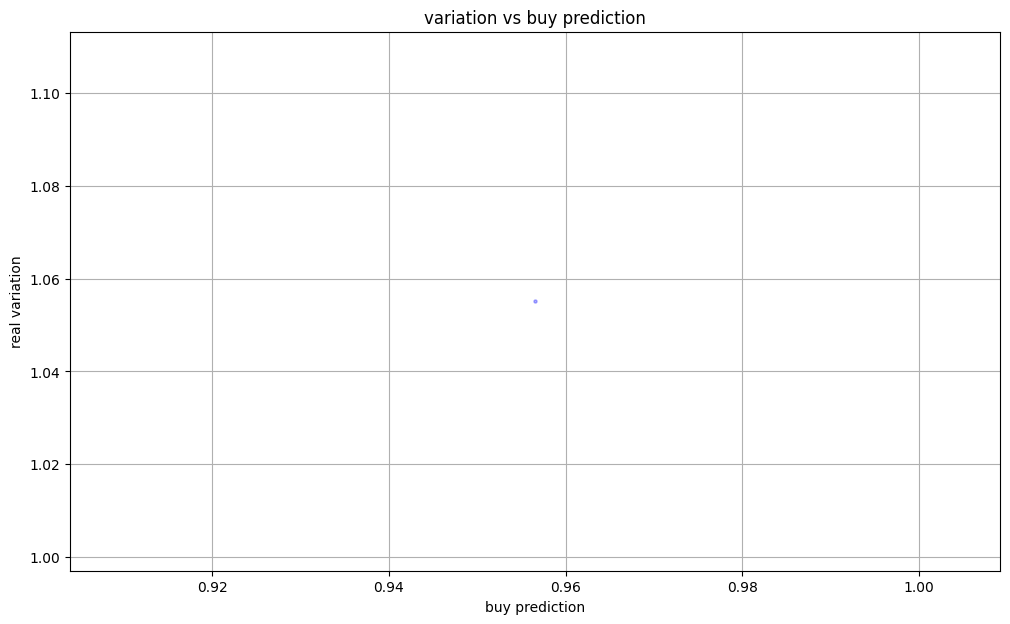

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.scatter(x=df_filtered_evaluation['buy'], y=df_filtered_evaluation['variation'], color='blue', alpha=0.3, s=5)
plt.title('variation vs buy prediction')
plt.xlabel('buy prediction')
plt.ylabel('real variation')
plt.grid(True)
plt.show()